In [425]:
import pandas as pd
import hvplot.pandas
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
import plotly.express as px


In [426]:
# Creating obect for the excel files
apparel_xl = pd.read_excel('Apparel.xlsx')
take_out_xl = pd.read_excel('Food_away_from_home.xlsx')
housing_xl = pd.read_excel('Philadelphia_housing.xlsx')
recreation_xl = pd.read_excel('Philly_Recreation.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'Apparel.xlsx'

In [428]:
# Creating csv's out of the excel object
apparel_csv = apparel_xl.to_csv('Philly_Apparel.csv')
take_out_csv = take_out_xl.to_csv('Philly_take_out.csv')
housing_csv = housing_xl.to_csv('Philly_housing.csv')
recreation_csv = recreation_xl.to_csv('Philly_Recreation.csv')

In [431]:
# Creating the dataframes from the csv's
Philly_apparel = pd.read_csv('apparel_clean.csv',index_col='Year')
Philly_commercial_food = pd.read_csv('food_clean.csv',index_col='Year')
Philly_housing = pd.read_csv('housing_clean.csv',index_col='Year')


In [432]:
# Cleaning the df columns to only include "Annual"
Philly_apparel = Philly_apparel[['Annual']]
Philly_commercial_food = Philly_commercial_food[['Annual']]
Philly_housing = Philly_housing[['Annual']]
# Philly_recreation = Philly_recreation[['Annual']]

In [433]:
# Rename columns
Philly_apparel.columns = ['PHL Apparel Annual']
Philly_commercial_food.columns = ['PHL Commercial Food Annual']
Philly_housing.columns = ['PHL Housing Annual']
# Philly_recreation.columns = ['PHL Recreation Annual']


In [434]:
# Combine the dataframes
df_list = [Philly_apparel,Philly_commercial_food,Philly_housing]

combined_df = pd.concat(df_list, axis=1, join='inner')
combined_df

,PHL Apparel Annual,PHL Commercial Food Annual,PHL Housing Annual
Year,,,
2012,112.280,198.335,299.124
2013,112.633,203.147,302.356
2014,112.205,208.462,309.193
2015,107.425,211.667,316.315
2016,110.940,215.071,320.564
2017,111.743,219.145,326.389
2018,110.423,222.673,331.801
2019,106.646,228.602,341.424
2020,104.952,238.666,350.596


In [435]:
# Df for Percent change year to year
pct_change_df = combined_df.pct_change()



In [436]:
# load env file
load_dotenv()

True

In [437]:
# Retreive API keys
public_key = os.getenv("ALPACA_API_KEY")
private_key = os.getenv("ALPACA_SECRET_KEY")
type(private_key)

str

In [438]:
# Create alpacas connection object
alpacas = tradeapi.REST(public_key, private_key, api_version="v2")

In [439]:
start = pd.Timestamp("2012-01-01", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()
timeframe="1Day"

In [440]:
real_estate = ["TSCO","DHI","LOW","LGIH"]
apparel = ["NKE", "UA","GPS", "LULU", "JWN"]
pleasure_food = ["MCD","YUM", "DRI", "QSR"]

def alpacas_api(symbols,timeframe, start,end):
    dataframe = alpacas.get_bars(symbols, timeframe=timeframe, start=start, end=end).df
    new_df = dataframe[['open','close','trade_count', 'symbol']]

    return new_df

Real_Estate_stocks = alpacas_api(real_estate, timeframe,start,end)
Apparel_stocks = alpacas_api(apparel, timeframe,start,end)
Food_stocks = alpacas_api(pleasure_food, timeframe,start,end)

In [441]:
# Create pivot tables for closing prices
Real_Estate_close = Real_Estate_stocks.pivot_table(values="close", index="timestamp",columns="symbol")
Apparel_close = Apparel_stocks.pivot_table(values="close", index="timestamp",columns="symbol")
Food_close = Food_stocks.pivot_table(values="close", index="timestamp",columns="symbol")

In [442]:
# Get the percetn changes for each column
apparel_pct_change = combined_df["PHL Apparel Annual"].pct_change()
Food_pct_change = combined_df["PHL Commercial Food Annual"].pct_change()
Housing_pct_change = combined_df["PHL Housing Annual"].pct_change()

In [ ]:
# compare the cpi among cities, do the cities face a similar rate of inflation?
# What industries become more expensive quicker in which cities 

In [ ]:
def concat_stocks_cpi(stock, cpi):
    df = pd.concat([stock,cpi], axis=1, join="inner")
    return df 

# grouped.groupby(pd.Grouper(key='timestamp', freq='1Y')).pct_change()

In [ ]:
# # Create functions to find the greatest annual increase and decrease for a given column
class Question_1:
    def chop_rows(dataframe):
        new_df = dataframe.iloc[3:]
        return new_df
    
    def max_max(dataframe):
        largest = dataframe.max()
        return largest
    
    def min_min(dataframe):
        smallest = dataframe.min()
        return smallest


# Question_1.max_max(Housing_pct_change)
Housing_pct_change







Year
2012         NaN
2013    0.010805
2014    0.022612
2015    0.023034
2016    0.013433
2017    0.018171
2018    0.016581
2019    0.029002
2020    0.026864
2021    0.014093
2022    0.000000
Name: PHL Housing Annual, dtype: float64

In [453]:
# Real_Estate_stocks.index = Real_Estate_stocks.index.year
Real_Estate_stocks = Real_Estate_stocks.resample("Y").mean()

Real_estate_stock_annual = Real_Estate_stocks["close"].pct_change()
Real_estate_stock_annual.index = Real_estate_stock_annual.index.year
Real_estate_stock_annual
# Housing_pct_change

timestamp
2015         NaN
2016   -0.022360
2017    0.029060
2018    0.231439
2019    0.170760
2020    0.275063
2021    0.536315
Name: close, dtype: float64

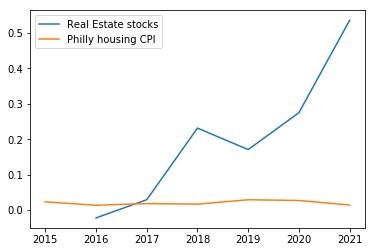

In [457]:
def concat_stocks_cpi(stock, cpi):
    df = pd.concat([stock,cpi], axis=1, join="inner")
    return df 

Housing_combined = concat_stocks_cpi(Real_estate_stock_annual, Housing_pct_change)
Housing_combined.columns = ['Real Estate stocks', "Philly housing CPI"]
Housing_combined.plot()